In [2]:
import sys
import os
os.chdir("/home/debian/PhenPred")
import importlib
import PhenPred
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from PhenPred.vae import shap_folder, plot_folder
import Shap_functions
from PhenPred.vae.Train import CLinesTrain
from PhenPred.vae.Hypers import Hypers
from PhenPred.vae.DatasetDepMap23Q2 import CLinesDatasetDepMap23Q2

/home/debian/miniconda3/envs/mosa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
importlib.reload(Shap_functions)

In [3]:
# order of explanation arrays
# proteomics, metabolomics, drugrespose, crisprcas9, methylation, transcriptomics, copynumber, conditionals
omics_dict = {
    "proteomics": 0,
    "metabolomics": 1,
    "drugrespose": 2,
    "crisprcas9": 3,
    "methylation": 4,
    "transcriptomics": 5,
    "copynumber": 6,
    "conditionals": 7
}

In [4]:
time_alldat = "20240805_132345" #all datasets, no dipvae
time_alldat_dis = "20240805_131847" #all datasets w/ disentanglement, lambda_d = 0.001, lambda_od = 0.001

target_latent = "latent"
target_drug = "drugresponse"

In [9]:
hyperparameters = Hypers.read_hyperparameters(timestamp=time_alldat)

# Load the first dataset
clines_db = CLinesDatasetDepMap23Q2(
    labels_names=hyperparameters["labels"],
    datasets=hyperparameters["datasets"],
    feature_miss_rate_thres=hyperparameters["feature_miss_rate_thres"],
    standardize=hyperparameters["standardize"],
    filter_features=hyperparameters["filter_features"],
    filtered_encoder_only=hyperparameters["filtered_encoder_only"],
)

# Train and predictions
train = CLinesTrain(
    clines_db,
    hyperparameters,
    stratify_cv_by=clines_db.samples_by_tissue("Haematopoietic and Lymphoid"),
    timestamp=time_alldat,
)

# ---- Hyperparameters
{
    "activation_function": "prelu",
    "batch_norm": false,
    "batch_size": 76,
    "contrastive_neg_margin": 0.15,
    "contrastive_pos_margin": 0.85,
    "dataname": "depmap23Q2",
    "datasets": {
        "copynumber": "/home/debian/PhenPred/data/clines//cnv_summary_20230303_matrix.csv",
        "crisprcas9": "/home/debian/PhenPred/data/clines//depmap23Q2/CRISPRGeneEffect.csv",
        "drugresponse": "/home/debian/PhenPred/data/clines//drugresponse.csv",
        "metabolomics": "/home/debian/PhenPred/data/clines//metabolomics.csv",
        "methylation": "/home/debian/PhenPred/data/clines//methylation.csv",
        "proteomics": "/home/debian/PhenPred/data/clines//proteomics.csv",
        "transcriptomics": "/home/debian/PhenPred/data/clines//depmap23Q2/OmicsExpressionGenesExpectedCountProfileVoom.csv"
    },
    "feature_dropout": 0,
    "feature_miss_rate_thres": 0.85,
    "filter_features": [
        "transcriptomics",
        "crisprcas9",
        "m

/home/debian/PhenPred/PhenPred/vae/DatasetDepMap23Q2.py:234: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.labels = self.labels.reindex(index=self.samples).fillna(0)


In [5]:
with open(f"{shap_folder}/files/{time_alldat}_explanation_{target_latent}.pkl", 'rb') as f:
    explanation = pickle.load(f)

In [10]:
sample_IDs = np.array(clines_db.samples)

In [6]:
shap_df = train.save_shap(explanation.values, target_latent)
columns_to_convert = shap_df.columns[2:]
shap_df[columns_to_convert] = shap_df[columns_to_convert].astype('float32')

In [9]:
shap_df

,target_name,Sample ID,proteomics_AAAS,proteomics_AACS,proteomics_AAGAB,proteomics_AAK1,proteomics_AAMDC,proteomics_AAMP,proteomics_AARS1,proteomics_AARS2,...,conditionals_mut_WNK4,conditionals_mut_WRN,conditionals_mut_ZEB1,conditionals_mut_ZFHX3,conditionals_mut_ZNF208,conditionals_mut_ZNF429,conditionals_mut_ZNF626,conditionals_mut_ZNF93,conditionals_mut_ZNRF3,conditionals_msi_status
0,Latent_1,SIDM00001,0.000173,8.800000e-06,0.000067,0.000189,-0.000090,-0.000062,0.000255,0.000136,...,0.000000,0.000000,-0.000001,-0.000134,0.000000,0.000033,0.000098,0.000043,0.000000,0.0
1,Latent_1,SIDM00003,-0.000506,2.370000e-05,0.000054,0.000244,-0.000119,0.000186,0.000028,0.000060,...,0.000016,0.000000,0.000000,0.001376,-0.000062,0.000000,0.000000,-0.000043,0.000000,0.0
2,Latent_1,SIDM00005,0.000274,1.550000e-05,-0.000153,0.000161,-0.000075,0.000067,0.000072,-0.000011,...,0.000032,0.000045,0.000000,0.000013,-0.000106,0.000060,0.000071,0.000030,0.000000,0.0
3,Latent_1,SIDM00006,0.000579,3.000000e-07,-0.000036,-0.000043,0.000011,-0.000106,-0.000188,0.000224,...,0.000000,0.000000,0.000000,0.000000,-0.000199,0.000000,0.000000,0.000000,0.000000,0.0
4,Latent_1,SIDM00007,-0.000094,-4.170000e-05,0.000024,0.000280,-0.000028,-0.000073,0.000531,0.000445,...,0.000035,0.000087,-0.000046,0.001703,-0.000304,0.000000,0.000059,0.000022,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,Latent_215,SIDM01979,0.000477,-1.591000e-04,-0.000053,-0.000100,0.000230,0.000164,-0.000094,-0.000180,...,0.000067,0.000000,0.000000,-0.000013,0.000168,0.000000,0.000000,-0.000033,-0.000127,0.0
1519,Latent_215,SIDM01980,0.000835,-3.558000e-04,-0.000274,0.000043,-0.000022,0.000085,-0.000010,-0.000125,...,-0.000009,0.000000,-0.000104,-0.000011,0.000000,0.000065,0.000000,-0.000095,-0.000142,0.0
1520,Latent_215,SIDM01981,0.000794,-2.244000e-04,-0.000167,-0.000006,-0.000138,0.000113,-0.000056,-0.000460,...,0.000017,0.000000,0.000000,-0.000030,0.000000,0.000057,0.000000,0.000000,-0.000301,0.0
1521,Latent_215,SIDM01983,0.000337,3.560000e-05,-0.000102,0.000169,-0.000037,-0.000088,0.000076,0.000007,...,0.000000,0.000000,0.000000,-0.000017,0.000207,0.000034,-0.000015,0.000000,0.000000,0.0


Group Absolute SHAP values by (feature, latent dimensions)

In [12]:
# This consumes a lot of RAM!
absmean_shap_lat = Shap_functions.meanabs_groupby_feature_target(shap_df)
absmean_shap_lat.to_feather('/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/absmean_shap_alldat_lat_nodipvae.feather') 

In [29]:
absmean_shap_lat = pd.read_feather('/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/absmean_shap_alldat_lat_nodipvae.feather')

In [30]:
absmean_shap_lat.sort_values(by='Mean Abs Shap Values', ascending=False).head(50) 

Mean Abs Shap Values
Features                                        target_name                      
conditionals_tissue_Haematopoietic and Lymphoid Latent_106               0.236105
                                                Latent_189               0.189153
                                                Latent_83                0.155250
                                                Latent_61                0.146819
                                                Latent_53                0.142046
conditionals_tissue_Lung                        Latent_106               0.129262
conditionals_tissue_Haematopoietic and Lymphoid Latent_200               0.128381
                                                Latent_150               0.126807
                                                Latent_154               0.113949
                                                Latent_183               0.103567
copynumber_CDKN2A                               Latent_106               0.103176
conditionals_tissue_Haematopoietic and Lymphoid Latent_64                0.097241
conditionals_tissue_Lung                        Latent_189               0.096498
conditionals_tissue_Haematopoietic and Lymphoid Latent_63                0.084342
                                                Latent_184               0.082789
                                                Latent_119               0.078082
                                                Latent_100               0.075012
                                                Latent_153               0.074829
copynumber_CDKN2A                               Latent_189               0.074760
copynumber_RSPH10B2                             Latent_206               0.071428
conditionals_tissue_Haematopoietic and Lymphoid Latent_129               0.070937
                                                Latent_205               0.069761
                                                Latent_132               0.066968
                                                Latent_79                0.065624
                                                Latent_131               0.064692
                                                Latent_12                0.064542
                                                Latent_57                0.062691
                                                Latent_125               0.060838
                                                Latent_135               0.060825
                                                Latent_48                0.060297
copynumber_RSPH10B2                             Latent_215               0.060030
conditionals_tissue_Haematopoietic and Lymphoid Latent_177               0.059685
                                                Latent_199               0.059256
                                                Latent_185               0.058544
copynumber_RSPH10B2                             Latent_131               0.058272
conditionals_tissue_Haematopoietic and Lymphoid Latent_66                0.057417
                                                Latent_34                0.057246
                                                Latent_74                0.057136
                                                Latent_50                0.055021
                                                Latent_214               0.054585
                                                Latent_20                0.054525
                                                Latent_93                0.052654
                                                Latent_211               0.052383
                                                Latent_158               0.051465
                                                Latent_178               0.050908
                                                Latent_151               0.050631
                                                Latent_139               0.050618
                                           

In [5]:
# Without dominant latent dimensions
df = absmean_shap_lat.reset_index()
df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106")].sort_values(by='Mean Abs Shap Values', ascending=False).head(50) 

,Features,target_name,Mean Abs Shap Values
46637,conditionals_tissue_Haematopoietic and Lymphoid,Latent_83,0.155250
46613,conditionals_tissue_Haematopoietic and Lymphoid,Latent_61,0.146819
46604,conditionals_tissue_Haematopoietic and Lymphoid,Latent_53,0.142046
46553,conditionals_tissue_Haematopoietic and Lymphoid,Latent_200,0.128381
46497,conditionals_tissue_Haematopoietic and Lymphoid,Latent_150,0.126807
46501,conditionals_tissue_Haematopoietic and Lymphoid,Latent_154,0.113949
46533,conditionals_tissue_Haematopoietic and Lymphoid,Latent_183,0.103567
46616,conditionals_tissue_Haematopoietic and Lymphoid,Latent_64,0.097241
46615,conditionals_tissue_Haematopoietic and Lymphoid,Latent_63,0.084342
46534,conditionals_tissue_Haematopoietic and Lymphoid,Latent_184,0.082789


In [13]:
df = absmean_shap_lat.reset_index()
df = df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106")].sort_values(by='Mean Abs Shap Values', ascending=False)

values_to_find = ["conditionals_mut_TP53", "conditionals_day4_day1_ratio"]

for value_to_find in values_to_find:
    # Finding the index of the first occurrence of the specified value in the 'Features' column
    first_occurrence_index = df[df['Features'] == value_to_find].index[0]

    # Displaying the row corresponding to the first occurrence
    first_occurrence_row = df.loc[first_occurrence_index]
    print(first_occurrence_row)

Features                conditionals_mut_TP53
target_name                        Latent_129
Mean Abs Shap Values                 0.026656
Name: 40453, dtype: object
Features                conditionals_day4_day1_ratio
target_name                               Latent_154
Mean Abs Shap Values                        0.022608
Name: 61, dtype: object


absmean_shap_lat Table visualization with line plot (with and without disentanglement)

In [30]:
absmean_shap_lat_dis = pd.read_feather('/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/absmean_shap_alldat_lat_withdipvae.feather')

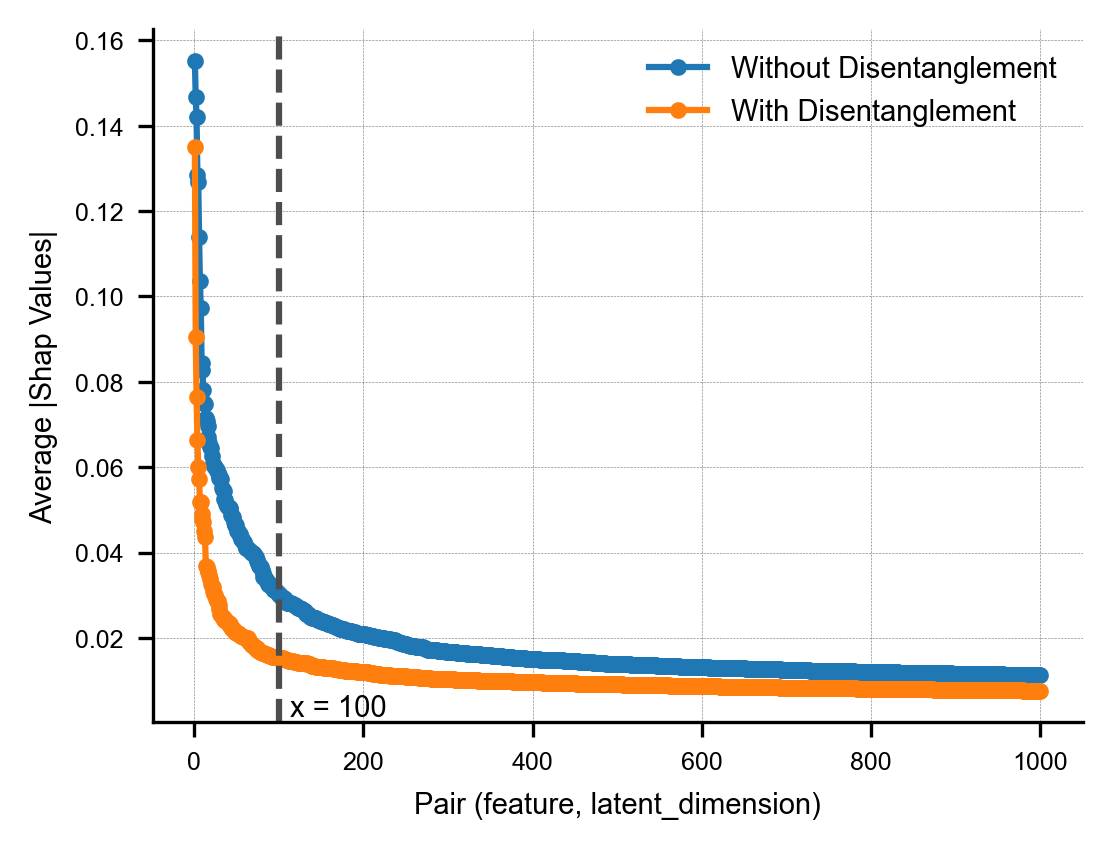

In [48]:
#After removing the two dominant latents in each model
df = absmean_shap_lat.reset_index()
df_dis = absmean_shap_lat_dis.reset_index()

df = df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106")]
df_dis = df_dis[(df_dis.target_name != "Latent_106") & (df_dis.target_name != "Latent_108")]

table_data = df.sort_values(by='Mean Abs Shap Values', ascending=False)["Mean Abs Shap Values"][:1000]
table_data_dis = df_dis.sort_values(by='Mean Abs Shap Values', ascending=False)["Mean Abs Shap Values"][:1000]

plt.figure(figsize=(4, 3))
plt.plot(range(1, len(table_data) + 1), table_data, marker='o', markersize = 3, label= "Without Disentanglement")
plt.plot(range(1, len(table_data_dis) + 1), table_data_dis, marker='o', markersize = 3, label= "With Disentanglement")

plt.xlabel('Pair (feature, latent_dimension)', fontsize=7)
plt.ylabel('Average |Shap Values|', fontsize=7)
plt.legend(fontsize=7)
plt.axvline(x=100, color='#4d4d4d', linestyle='--')
plt.text(170, plt.ylim()[1]*0.01, 'x = 100', color='black', ha='center', fontsize=7)
plt.show()

Heatmap with features in the top x pairs of the previous plot

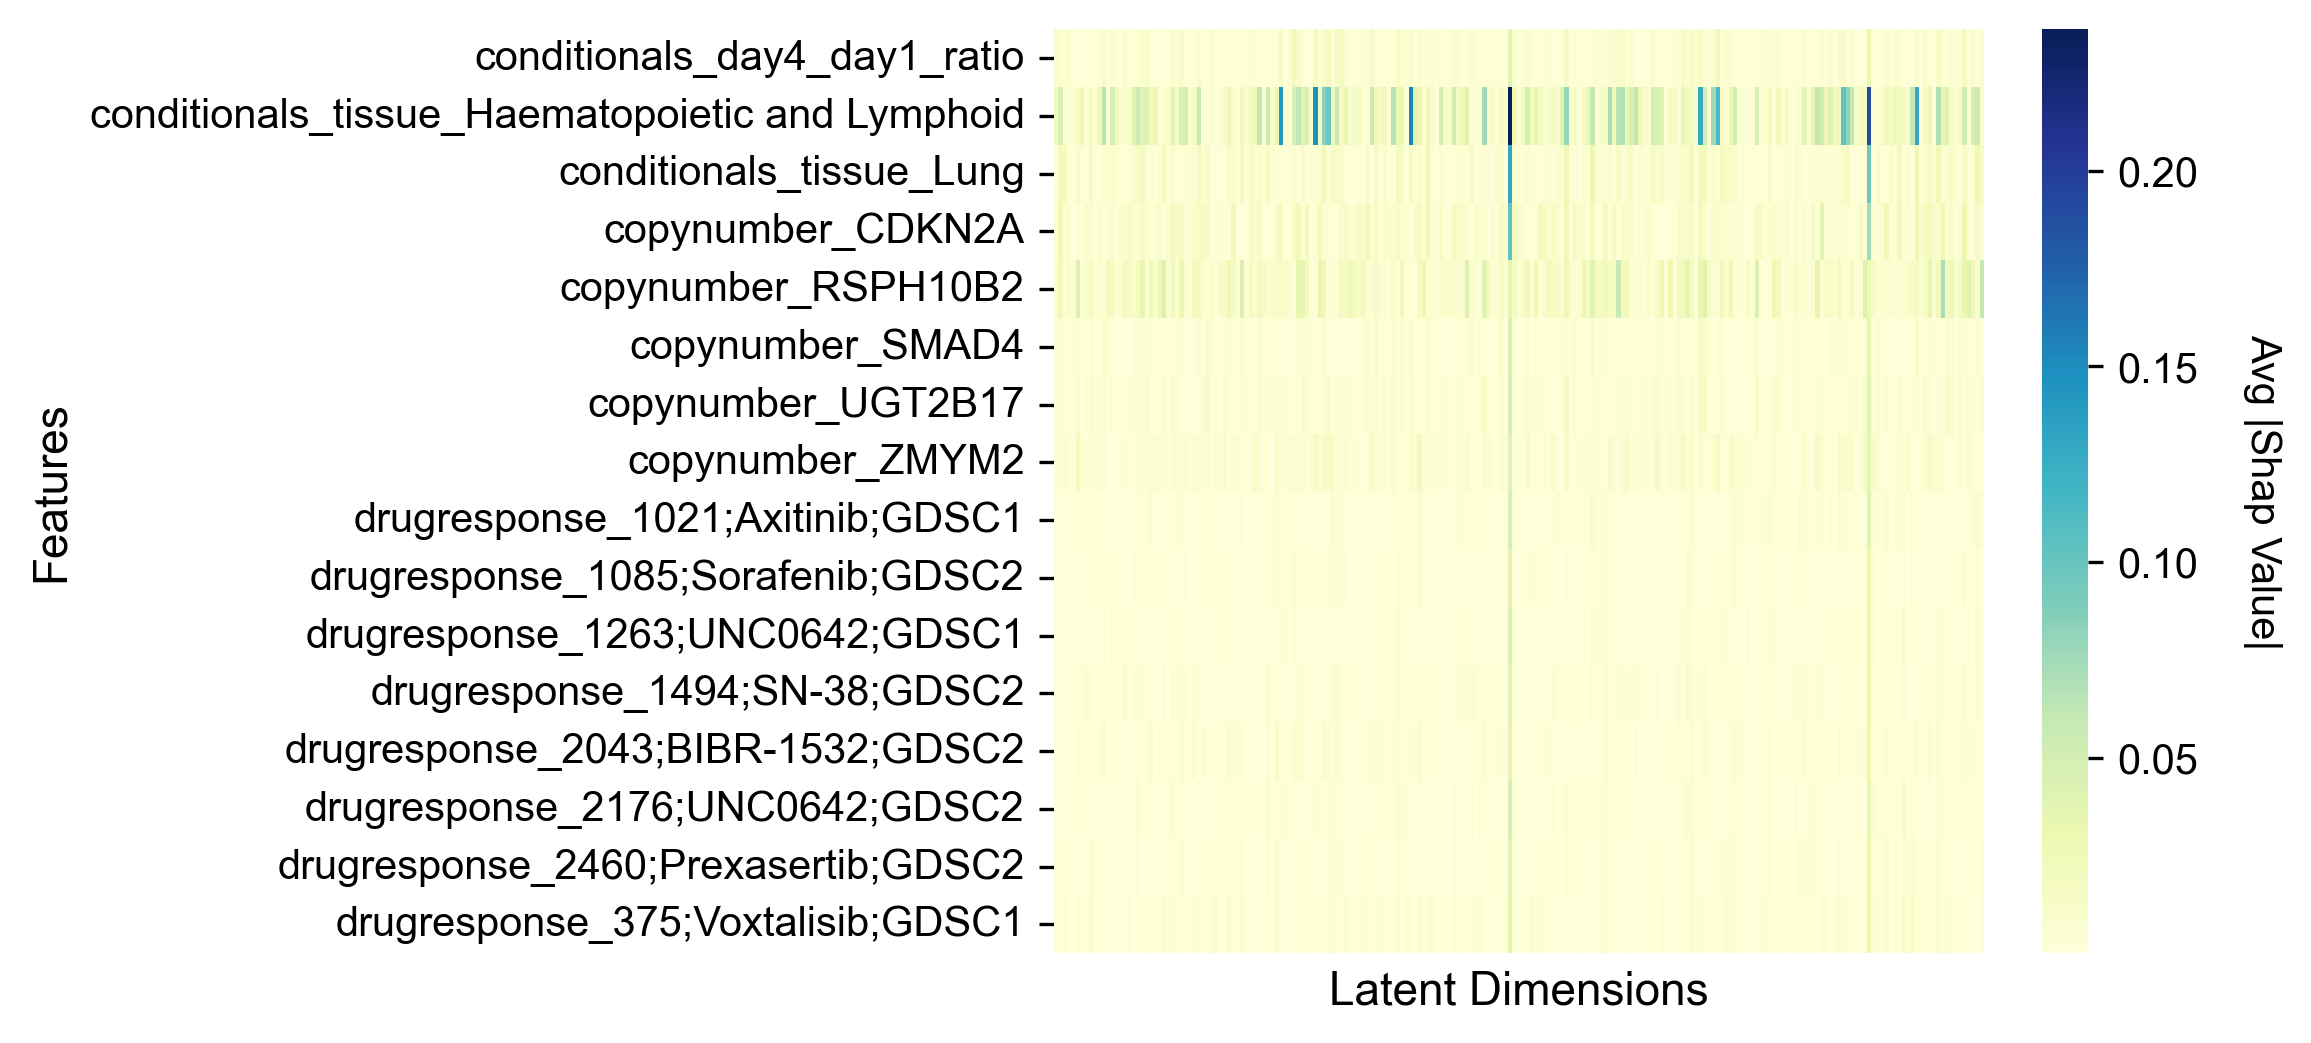

In [22]:
# top 100
Shap_functions.heatmap_features_vs_latents(100, absmean_shap_lat)

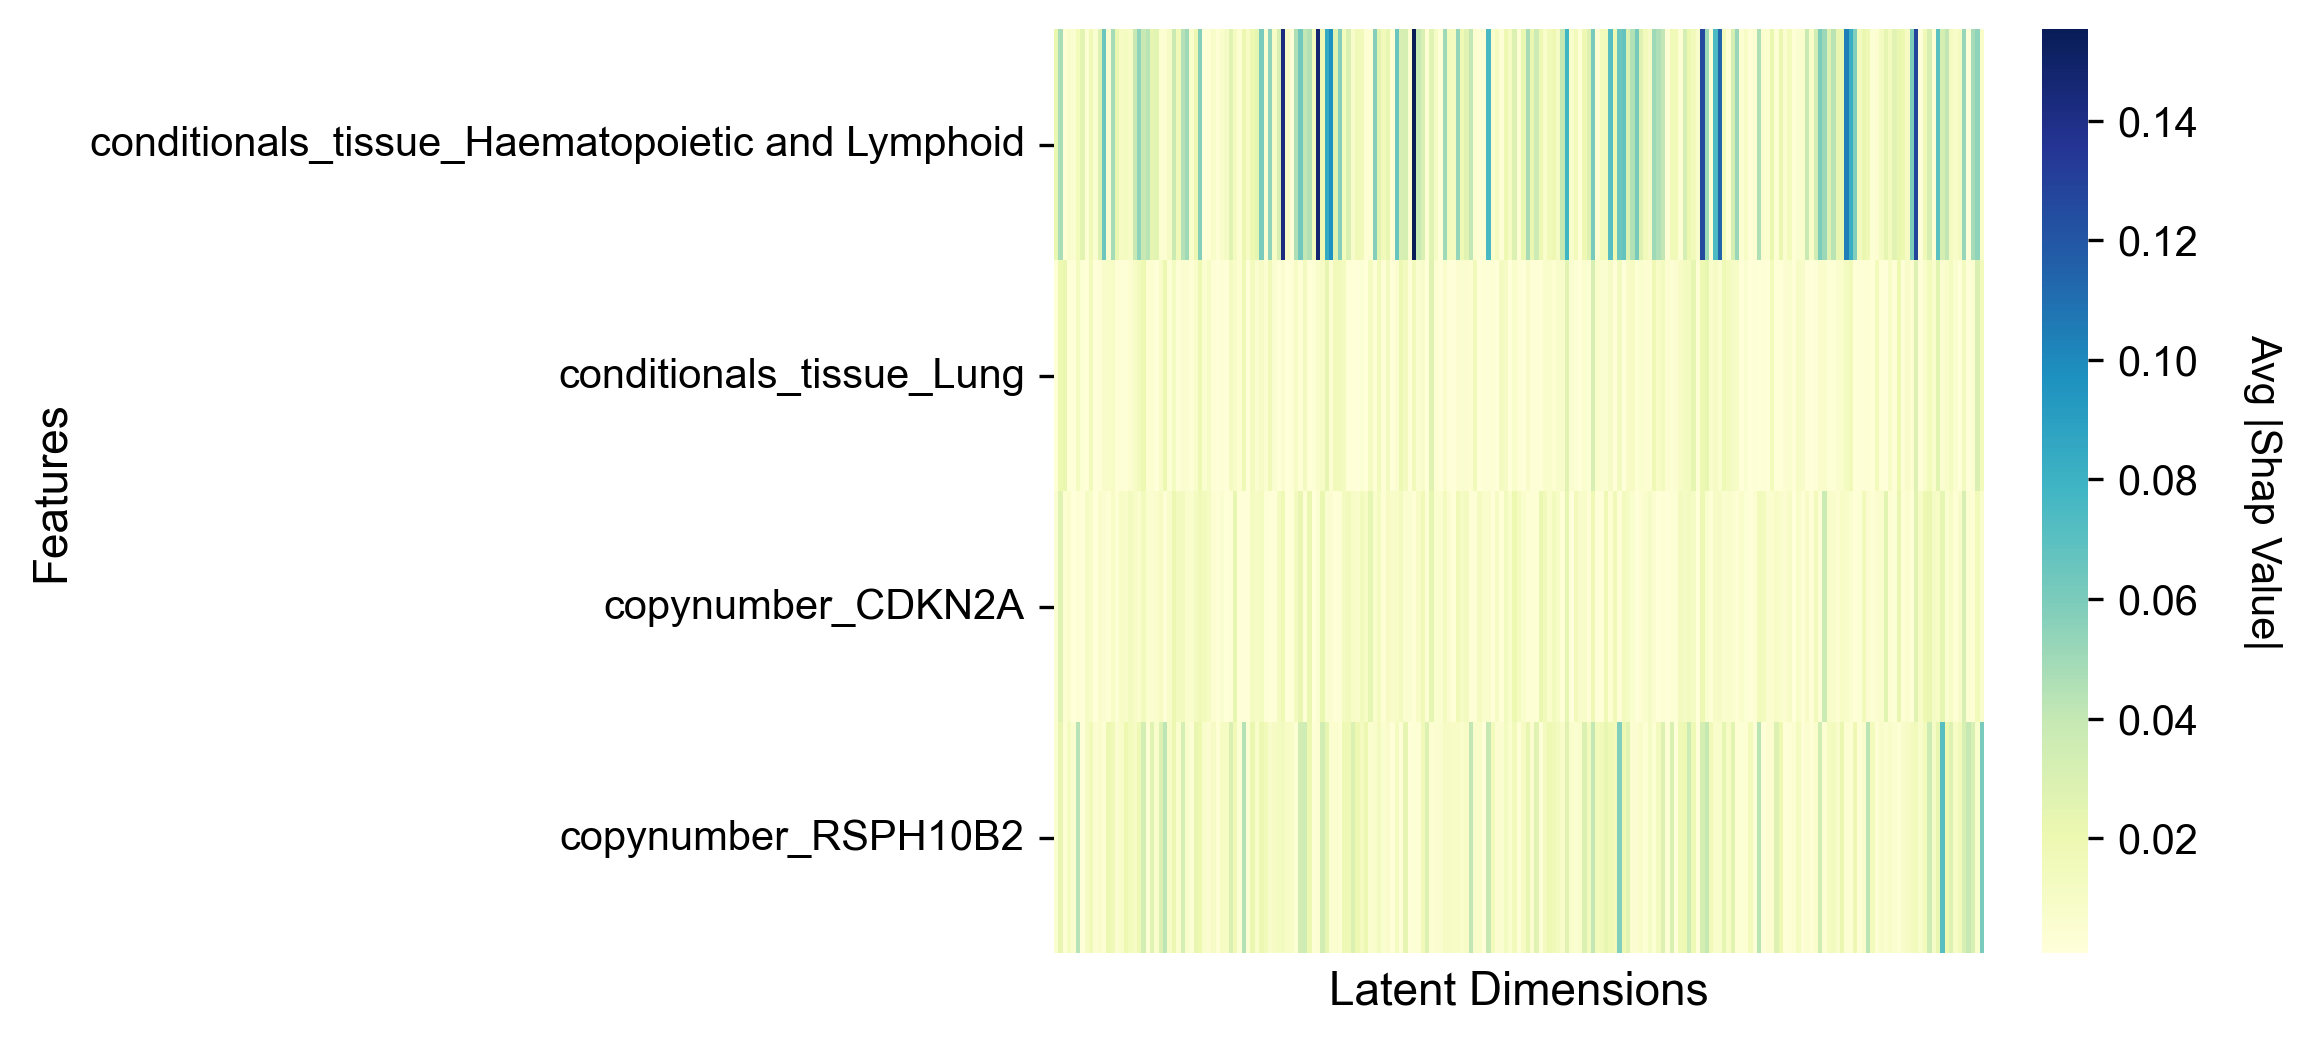

In [21]:
# After dropping dominant latents
df = absmean_shap_lat.reset_index()
Shap_functions.heatmap_features_vs_latents(100, df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106")])

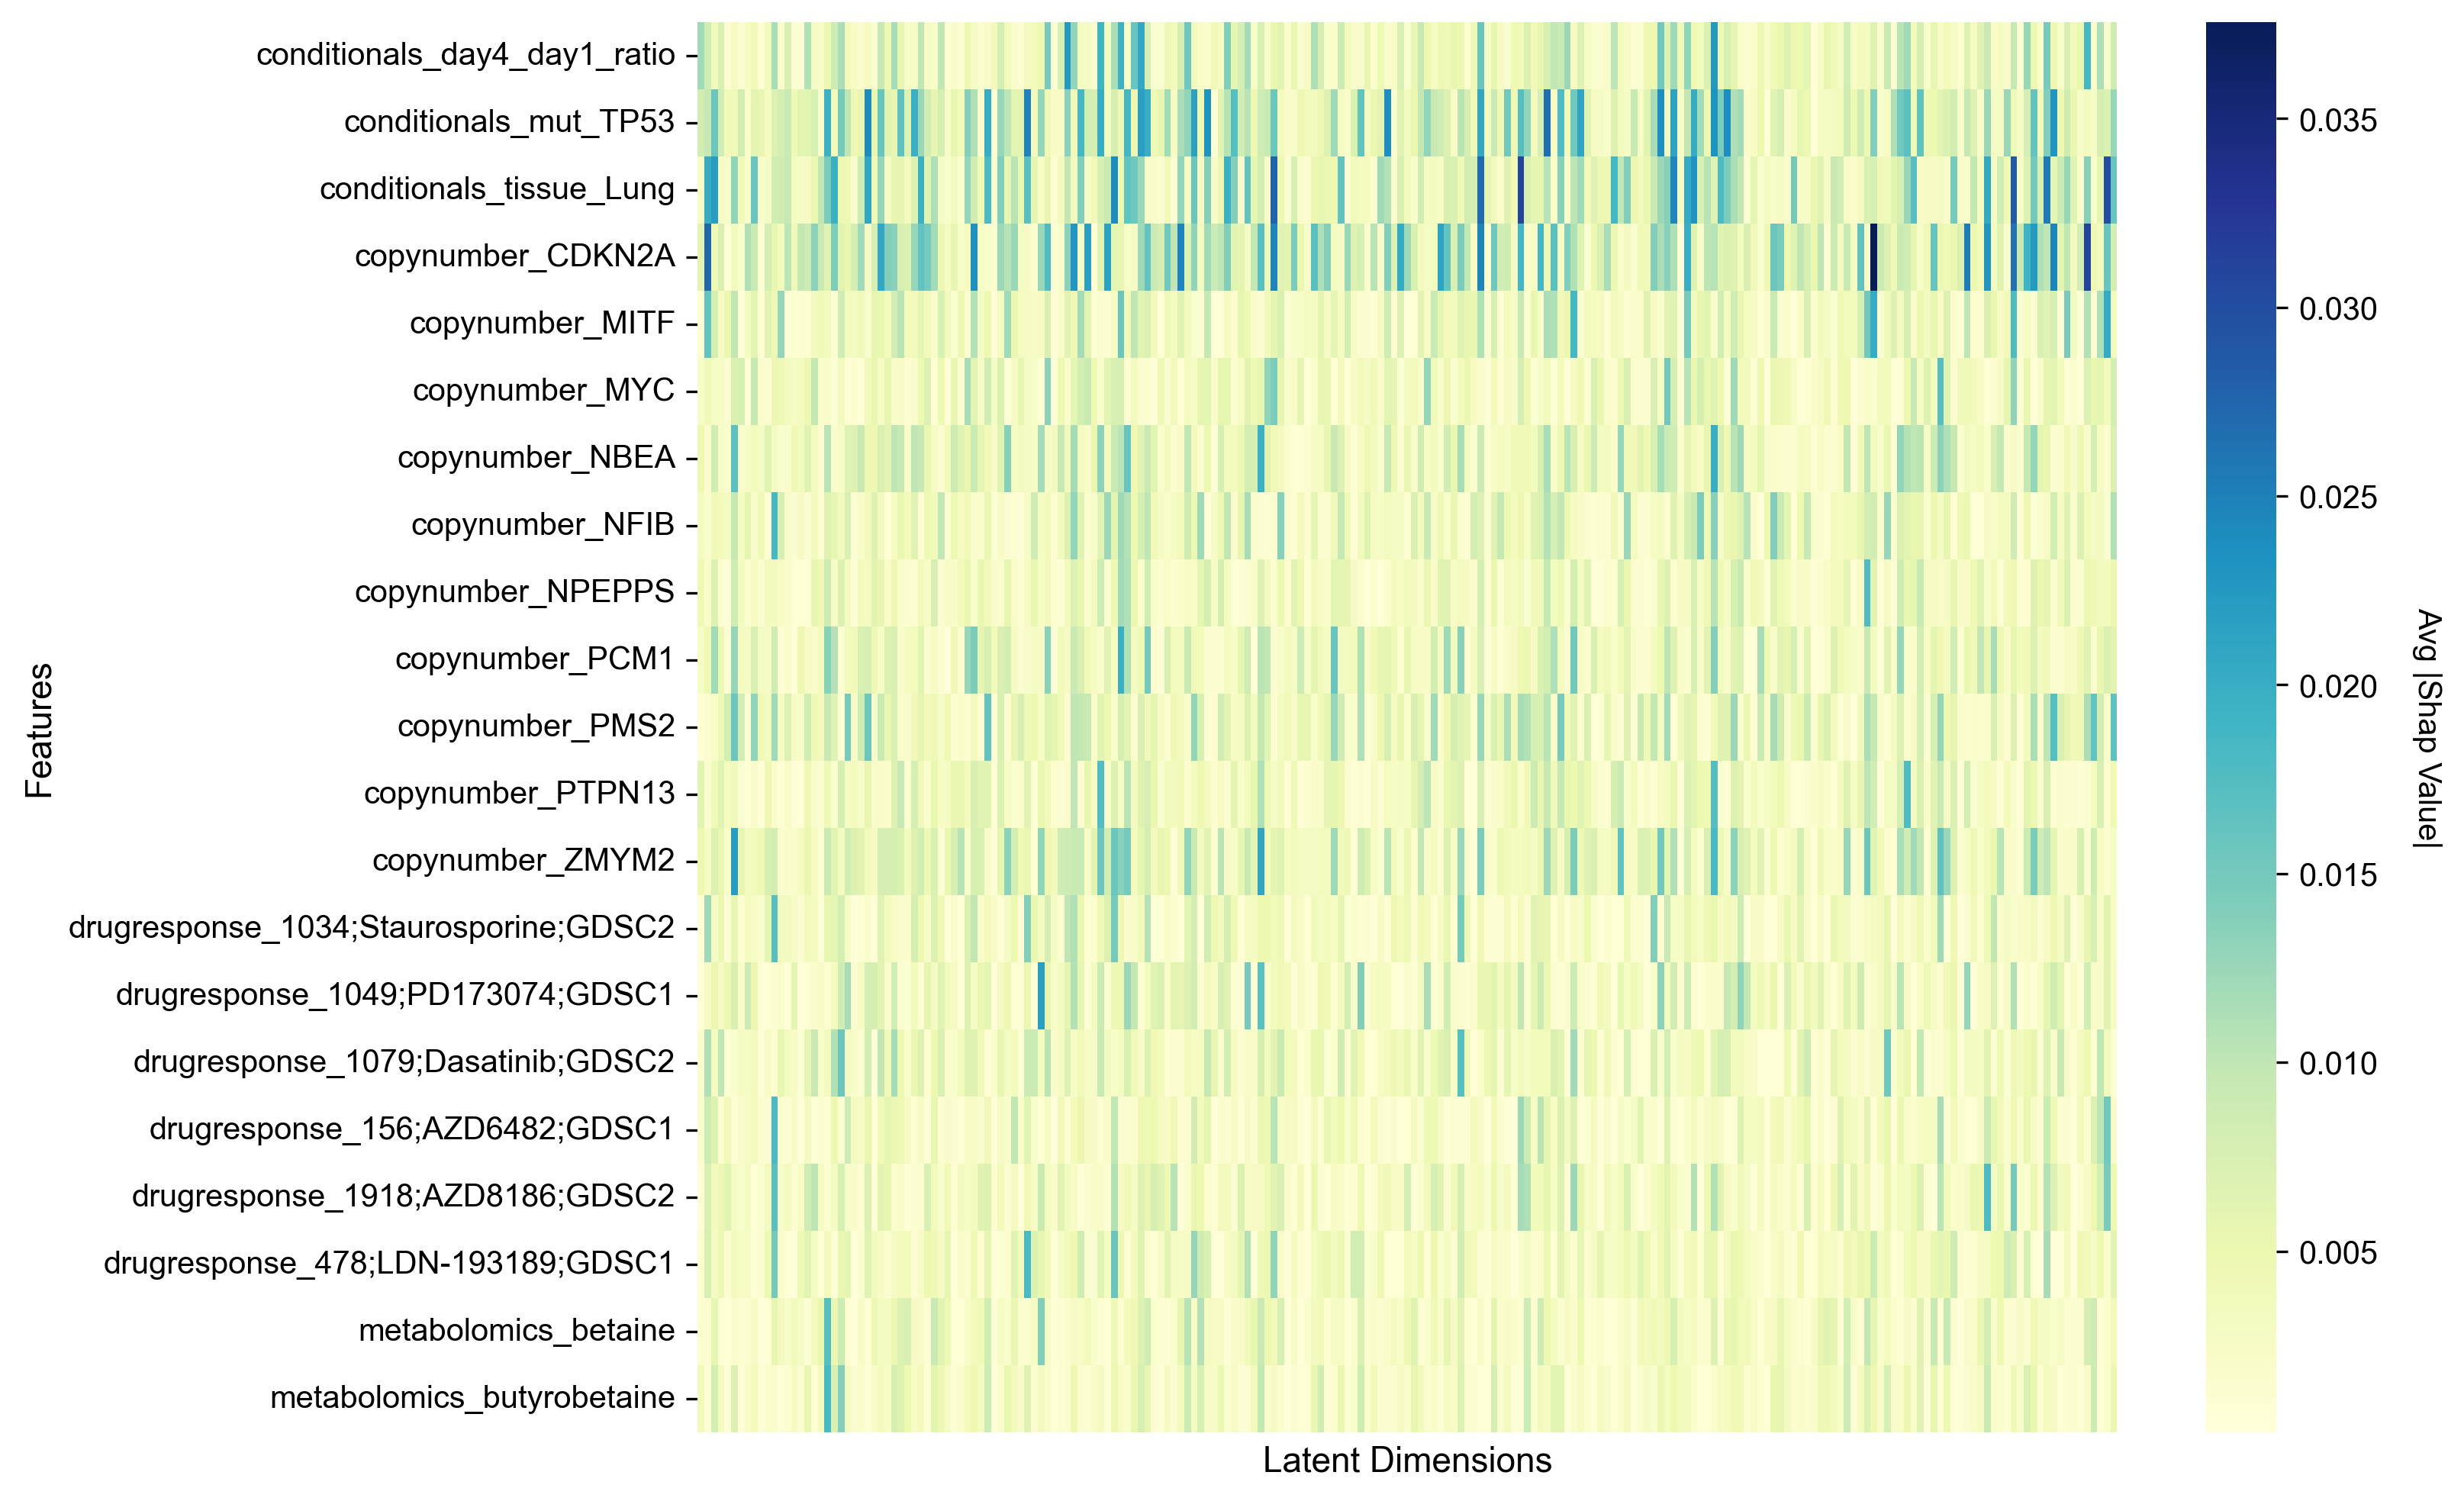

In [23]:
# After dropping latent 106 and 189 and features conditionals_tissue_Haematopoietic and Lymphoid and copynumber_RSPH10B2
df = absmean_shap_lat.reset_index()
Shap_functions.heatmap_features_vs_latents(100, df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106") & (df.Features != "conditionals_tissue_Haematopoietic and Lymphoid") & (df.Features != "copynumber_RSPH10B2")])

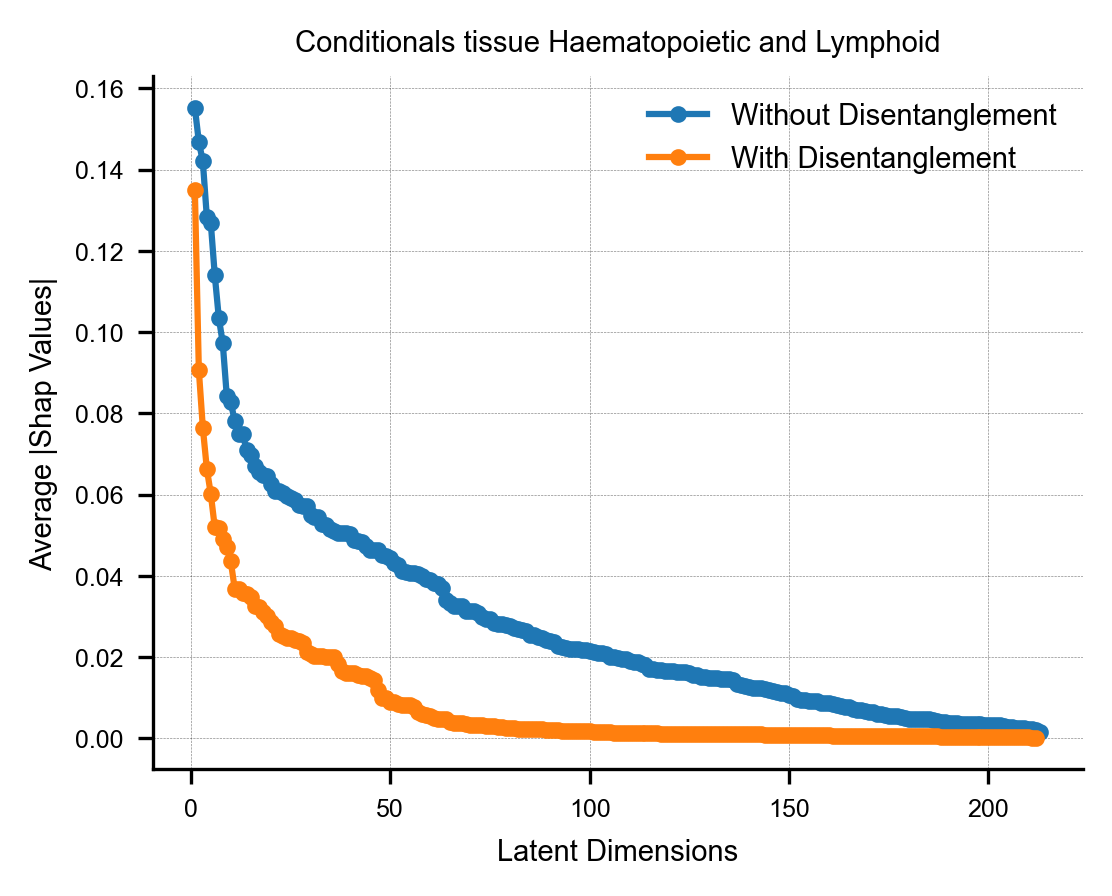

In [47]:
#Without the two latents in each model, Conditionals tissue Haematopoietic and Lymphoid feaute
df = absmean_shap_lat.reset_index()
df_dis = absmean_shap_lat_dis.reset_index()

df = df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106") & (df.Features == "conditionals_tissue_Haematopoietic and Lymphoid")]
df_dis = df_dis[(df_dis.target_name != "Latent_106") & (df_dis.target_name != "Latent_108") & (df.Features == "conditionals_tissue_Haematopoietic and Lymphoid")]

table_data = df.sort_values(by='Mean Abs Shap Values', ascending=False)["Mean Abs Shap Values"]
table_data_dis = df_dis.sort_values(by='Mean Abs Shap Values', ascending=False)["Mean Abs Shap Values"]

plt.figure(figsize=(4, 3))
plt.plot(range(1, len(table_data) + 1), table_data, marker='o', markersize = 3, label= "Without Disentanglement")
plt.plot(range(1, len(table_data_dis) + 1), table_data_dis, marker='o', markersize = 3, label= "With Disentanglement")
plt.xlabel('Latent Dimensions', fontsize=7)
plt.ylabel('Average |Shap Values|', fontsize=7)
plt.title('Conditionals tissue Haematopoietic and Lymphoid')
plt.legend(fontsize=7)
plt.show()

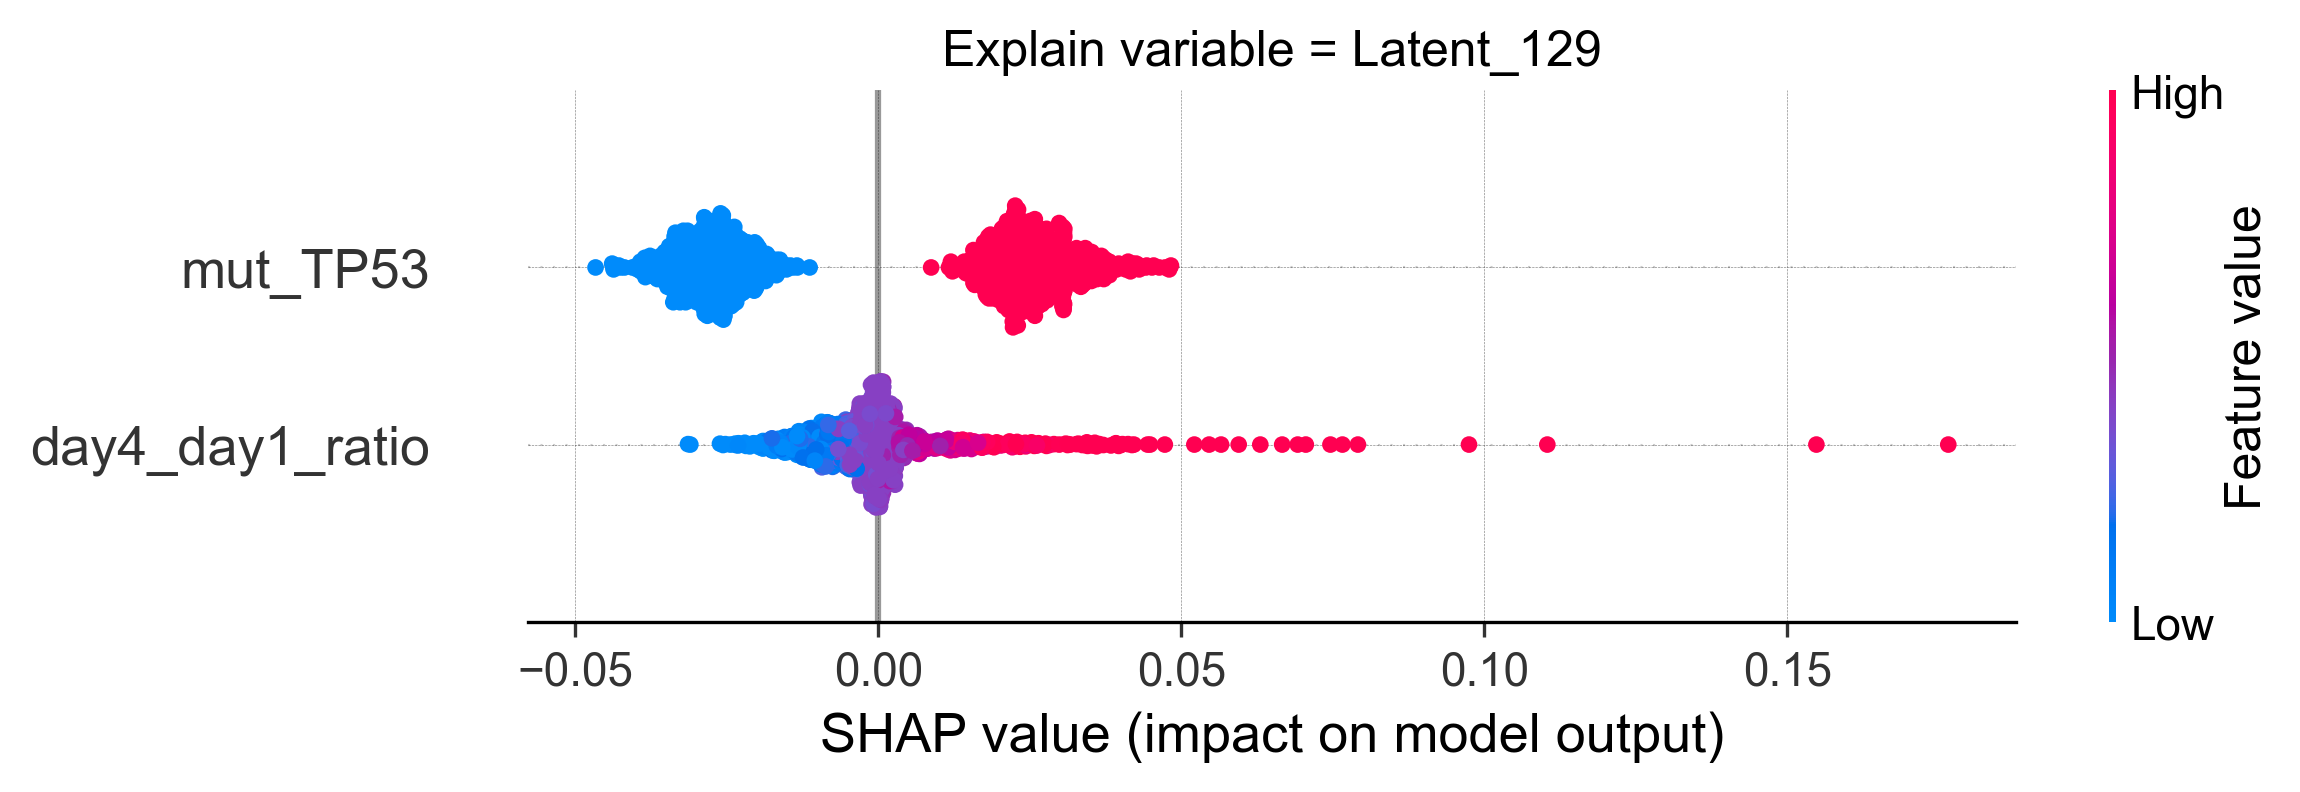

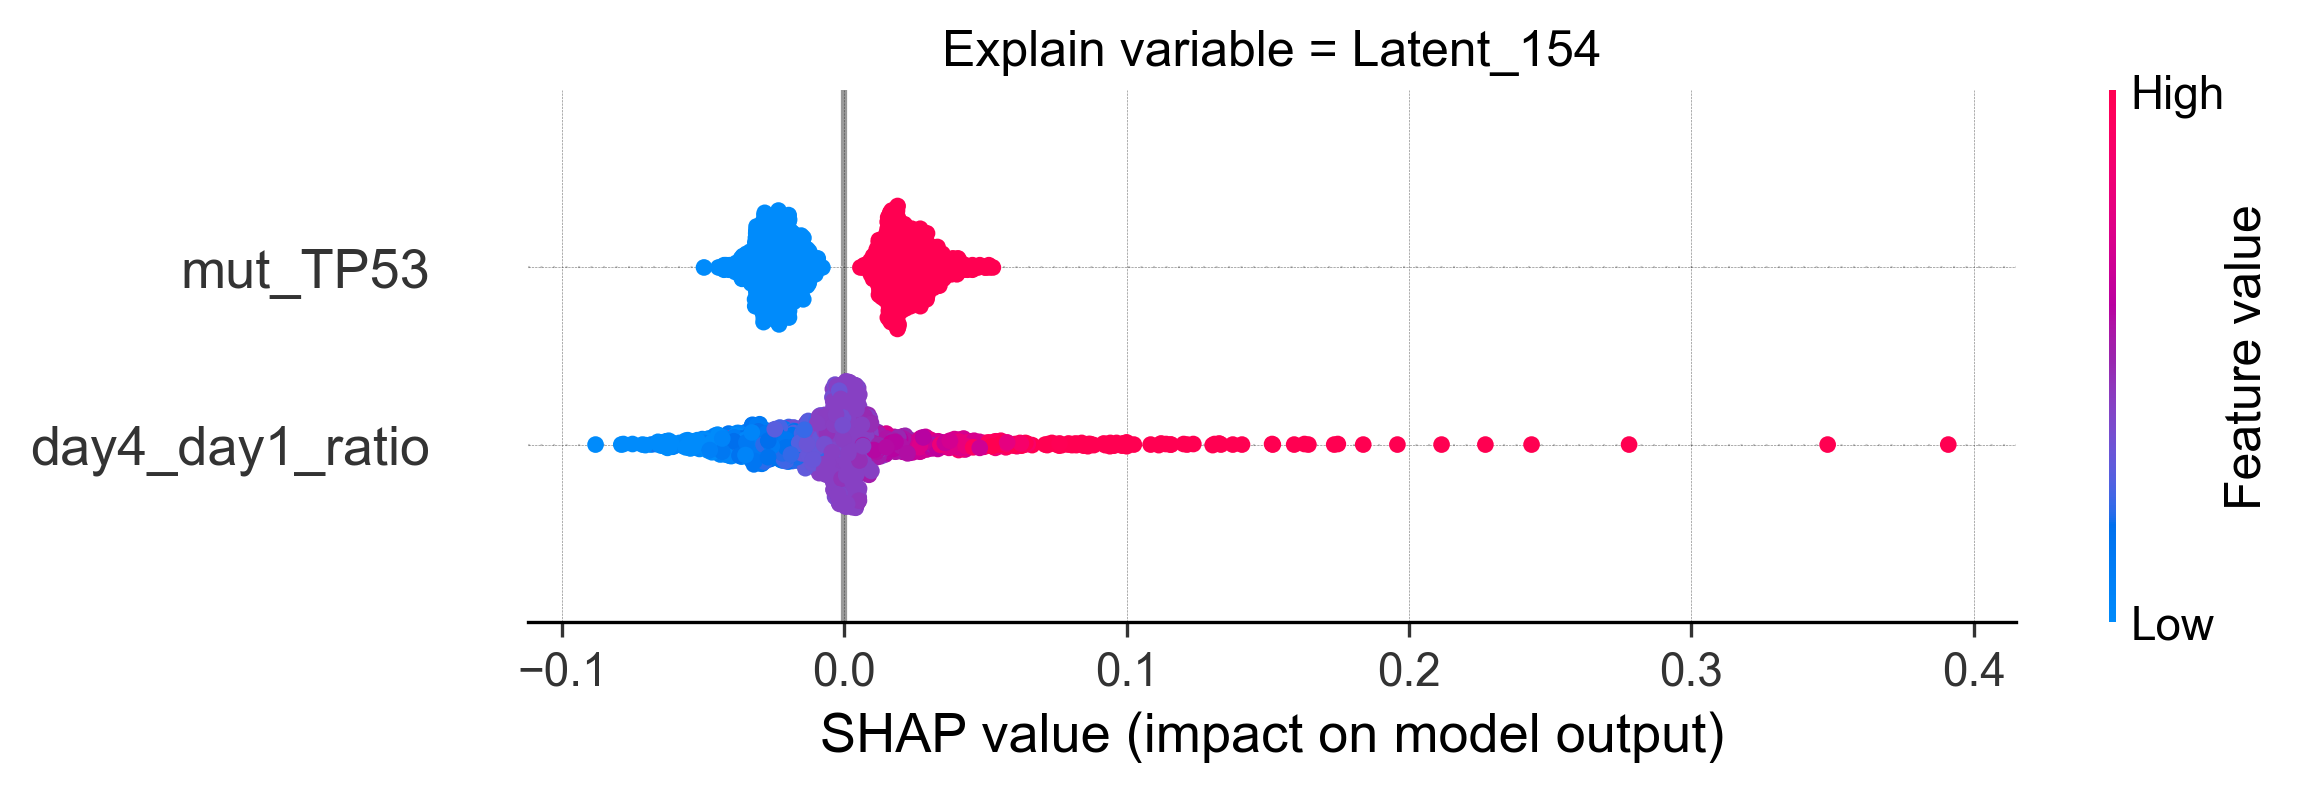

In [45]:
explain_targets_idx = [129, 154]
explain_targets = [f"Latent_{i}" for i in explain_targets_idx]
explain_targets_and_idx = {key: value-1 for key, value in zip(explain_targets, explain_targets_idx)}

for explain_target in explain_targets:
    plt.title(f'Explain variable = {explain_target}', fontsize = 12)
    shap.plots.beeswarm(explanation[omics_dict["conditionals"]][:, ["mut_TP53", "day4_day1_ratio"], explain_targets_and_idx[explain_target]])
    plt.show()


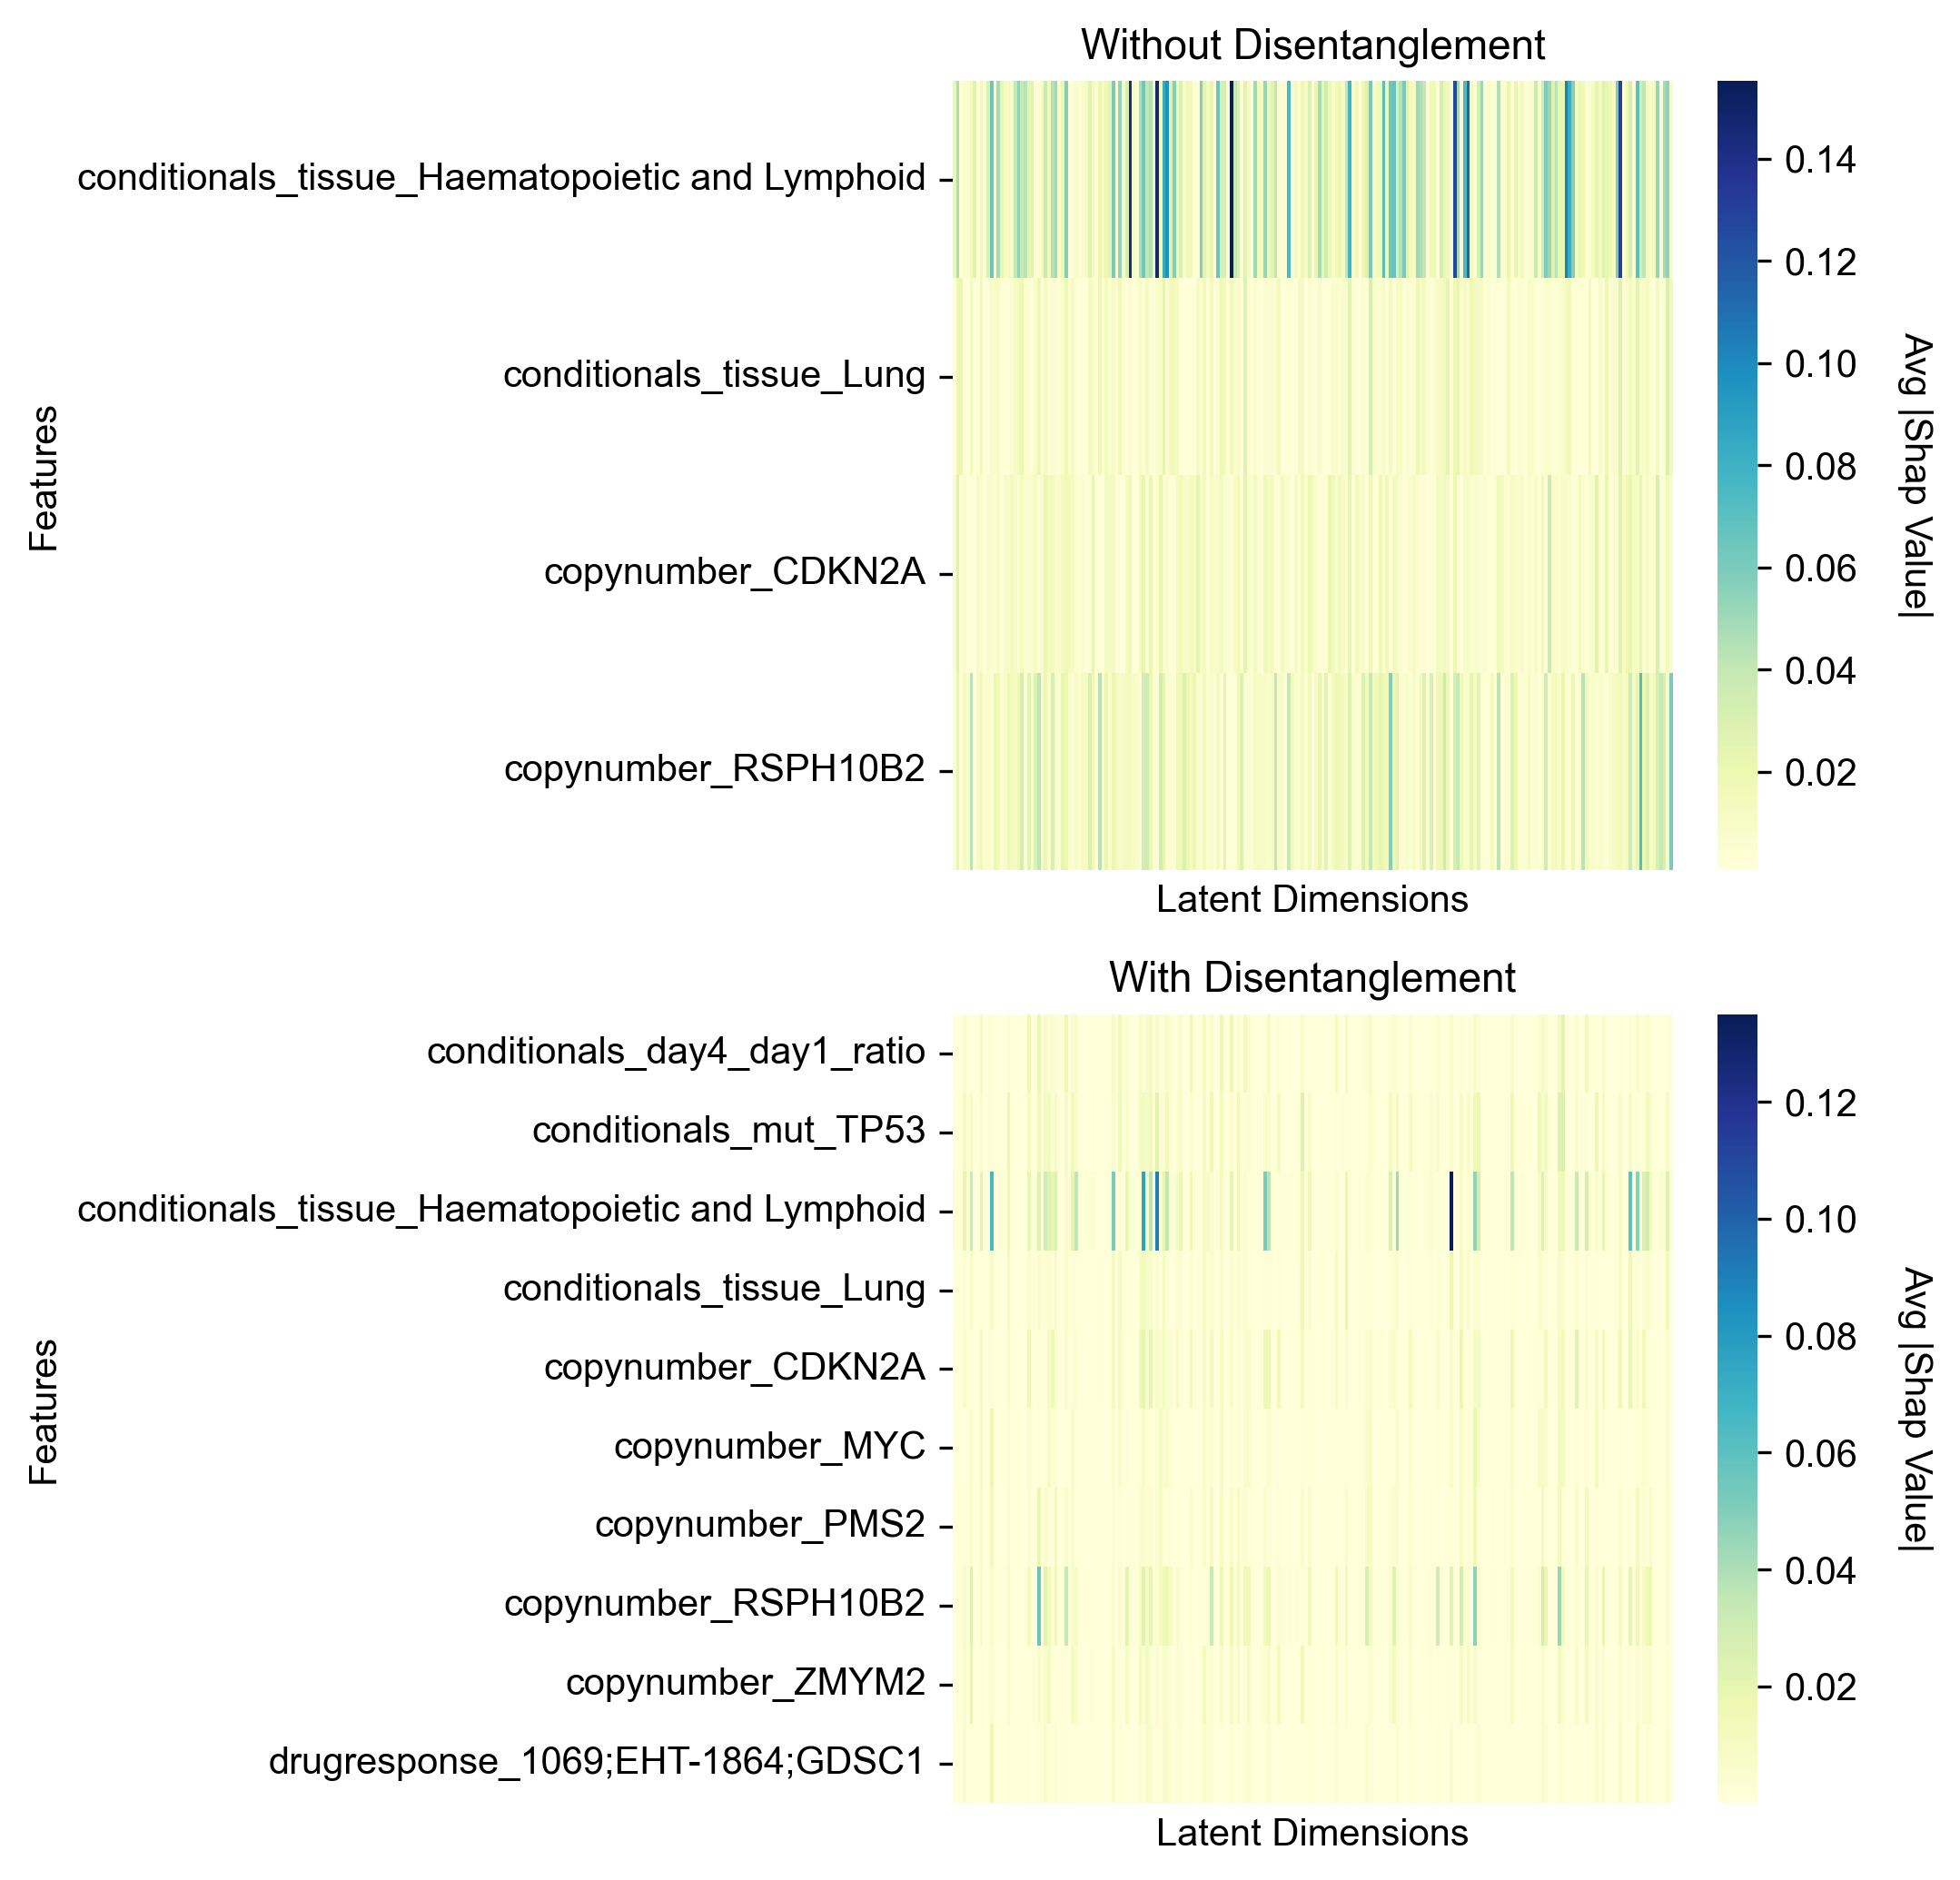

In [46]:
x = 100

df = absmean_shap_lat.reset_index()
df_2 = df[(df.target_name != "Latent_189") & (df.target_name != "Latent_106")]
top_x_entries = df_2.sort_values(by='Mean Abs Shap Values', ascending=False).head(x) 
features = top_x_entries.reset_index()["Features"].unique()

table_data = df_2.reset_index()
table_data = table_data[table_data['Features'].isin(features)]

heatmap_data1 = table_data.pivot(index='Features', columns='target_name', values='Mean Abs Shap Values')
latent_columns1 = sorted([col for col in heatmap_data1.columns if col.startswith('Latent_')], 
                    key=lambda x: int(x.split('_')[1]))
heatmap_data_ordered1 = heatmap_data1[latent_columns1]

df = absmean_shap_lat_dis.reset_index()
df_2 = df[(df.target_name != "Latent_108") & (df.target_name != "Latent_106")]
top_x_entries = df_2.sort_values(by='Mean Abs Shap Values', ascending=False).head(x) 
features = top_x_entries.reset_index()["Features"].unique()

table_data = df_2.reset_index()
table_data = table_data[table_data['Features'].isin(features)]

heatmap_data2 = table_data.pivot(index='Features', columns='target_name', values='Mean Abs Shap Values')
latent_columns2 = sorted([col for col in heatmap_data2.columns if col.startswith('Latent_')], 
                    key=lambda x: int(x.split('_')[1]))
heatmap_data_ordered2 = heatmap_data2[latent_columns2]

fig, ax = plt.subplots(2, 1, figsize=(7, 7))  

sns.heatmap(heatmap_data_ordered1, cmap="YlGnBu", annot=False, ax=ax[0])  
ax[0].set_xlabel('Latent Dimensions', fontsize=10)
ax[0].set_ylabel('Features', fontsize=10)
ax[0].yaxis.set_tick_params(rotation=0, labelsize=10)
ax[0].set_xticks([])  
ax[0].set_title("Without Disentanglement", fontsize=11)

cbar = ax[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Avg |Shap Value|", fontsize=10, rotation=270, labelpad=20)

sns.heatmap(heatmap_data_ordered2, cmap="YlGnBu", annot=False, ax=ax[1]) 
ax[1].set_xlabel('Latent Dimensions', fontsize=10)
ax[1].set_ylabel('Features', fontsize=10)
ax[1].yaxis.set_tick_params(rotation=0, labelsize=10)
ax[1].set_xticks([])  
ax[1].set_title("With Disentanglement", fontsize=11)
cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Avg |Shap Value|", fontsize=10, rotation=270, labelpad=20)

plt.tight_layout()
plt.show()